In [2]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 
from sklearn.metrics import mean_absolute_error

2021-09-25 09:24:09.941839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-25 09:24:09.941869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
raw_dataset = pd.read_csv('./station_rio.csv', index_col='YEAR')
raw_dataset = raw_dataset.iloc[:,:12]

In [32]:
def split_dataset(data):
    # split into standard weeks
    train, test = data[:-24], data[-24:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/12))
    test = np.array(np.split(test, len(test)/12))
    return train, test

def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

def fit_model(train_x, test_y, verbose):
    # define parameters
    epochs, batch_size = 70, 20
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
    
    return model

In [33]:
series = []

#Turning dataset into a serie
for year in range(len(raw_dataset.values)):
    for month in raw_dataset.values[year]:
        series.append(month)

# Handling wrong values
for i in range(len(series)):
    if series[i] > 60:
        num1 = 0
        num2 = 0
        
        k = 0
        while series[k] > 60:
            k = k+1
        num1 = series[k]
        
        k = 0
        while series[k] > 60:
            k = k-1
        num2 = series[k]
        
        series[i] = (num1 + num2)/2


series = np.array(series)
series.shape = (series.shape[0],1)
train, test = split_dataset(series)

n_input=12
train_x, train_y = to_supervised(train, 12, 12)
test_x, test_y = to_supervised(train, 12, 12)

In [34]:
model = fit_model(train_x, train_y, 0)

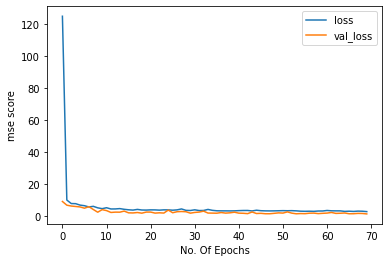

In [35]:
plt.plot(model.history.history["loss"],label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")
plt.show()

In [36]:
test_x, test_y = test[0], test[1]
pred_y = model.predict(test_x.reshape((1,12,1)))
pred_y = pred_y[0]

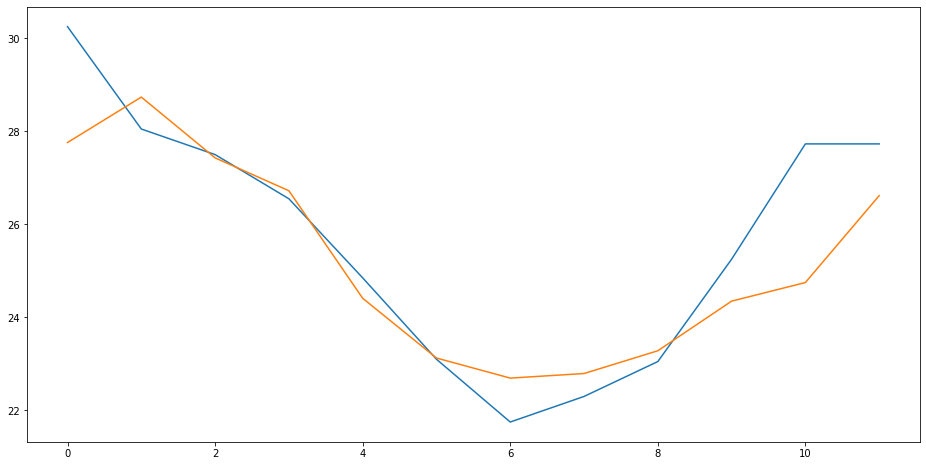

In [37]:
plt.figure(figsize=(16, 8))
plt.plot(test_y, label='true')
plt.plot(pred_y, label='predicted')
plt.show()